In [1]:
"""
IMPORTS
"""

import ROOT
import uproot
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import *
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime, timedelta


# Get all target polarizations from RCDB
import glob
import sys
sys.path.append("/work/clas12/users/gmat/packages/clas12root/rcdb/python/")
import rcdb
from rcdb.provider import RCDBProvider
from rcdb.model import ConditionType
os.getcwd()

Welcome to JupyROOT 6.22/06


/opt/root/lib/ROOT/_facade.py:121: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  return _orig_ihook(name, *args, **kwds)


'/w/hallb-scshelf2102/clas12/users/gmat/rgcTargetPolarization/tools'

# Functions
---
Simply compile these and then move onto the Main Code segment

In [2]:
"""
Dictionary for the theoretical A_LL asymmetries
These were provided by Sebastian Kuhn
"""

theory_A_LL = {}
theory_A_LL["NH3"] = pd.read_csv("/work/clas12/users/gmat/rgcTargetPolarization/tools/sebastian_A_LL_p.txt",sep=" ",names=["xmin","xmax","Q2min","Q2max","A_LL"]) # proton target
theory_A_LL["ND3"] = pd.read_csv("/work/clas12/users/gmat/rgcTargetPolarization/tools/sebastian_A_LL_d.txt",sep=" ",names=["xmin","xmax","Q2min","Q2max","A_LL"]) # deuteron target

"""
Pandas dataframe for the dilution factors
"""

dilutiondf=pd.read_csv("/work/clas12/users/gmat/rgc_dilution_factor_v4.csv")

In [3]:
def get_rcdb_tpols(min_run, max_run,target=""):
    """
    Return list of RCDB runs and tpols (for plotting later)
    
    :param min_run: Minimum run in the list
    :param max_run: Maximum run in the list
    :param target: (Optional) Only use this target for the RCDB
    :return _rcdb_run, _rcdb_Tpol: List of rcdb runs and correspond Tpols
    """
    
    db = RCDBProvider("mysql://rcdb@clasdb/rcdb")
    
    _rcdb_run = np.arange(min_run,max_run)
    _rcdb_Tpol = np.zeros(len(_rcdb_run))
    for i in range(len(_rcdb_run)):
        run = db.get_run(_rcdb_run[i])
        if(run):
            target_pol_cnd = run.get_condition('target_polarization')
            if target:
                if not run.get_condition('target'):
                    _rcdb_Tpol[i]=0.0
                    continue
                if target not in run.get_condition('target').value:
                    _rcdb_Tpol[i]=0.0
                    continue
            if(target_pol_cnd):
                _rcdb_Tpol[i] = target_pol_cnd.value
            else:
                _rcdb_Tpol[i] = 0.0
        else:
            _rcdb_Tpol[i] = 0.0
    return _rcdb_run, _rcdb_Tpol

In [4]:
def get_rcdb_dates(min_run, max_run):
    """
    Return list of RCDB dates (for plotting later)
    
    :param min_run: Minimum run in the list
    :param max_run: Maximum run in the list
    :return valid_runs, valid_dates: List of found rcdb runs and correspond dates
    """
    
    db = RCDBProvider("mysql://rcdb@clasdb/rcdb")
    
    _rcdb_run = np.arange(min_run,max_run)
    valid_runs = []
    valid_dates = []

    for i in range(len(_rcdb_run)):
        run = db.get_run(_rcdb_run[i])
        if(run):
            date_cnd = run.get_condition('run_start_time')
            if(date_cnd):
                valid_dates.append(date_cnd.value)
                valid_runs.append(_rcdb_run[i])
    valid_dates = np.array([date.strftime('%m/%d/%Y') for date in valid_dates])
    return valid_runs, valid_dates

In [5]:
def filter_dates_with_indices(dates, n):
    # Convert string dates to datetime objects
    date_objects = [datetime.strptime(date, "%m/%d/%Y") for date in dates]
    
    # Initialize the list with the first date and its index
    filtered_dates = [date_objects[0]]
    filtered_indices = [0]  # Store the index of the first date
    
    # Set the current reference date
    current_date = date_objects[0]
    
    # Iterate through the list of date objects
    for index, date in enumerate(date_objects[1:], start=1):
        if date >= current_date + timedelta(days=n):
            filtered_dates.append(date)
            filtered_indices.append(index)
            current_date = date  # Update the reference date

    # Always include the last date if it's not already included
    if filtered_dates[-1] != date_objects[-1]:
        filtered_dates.append(date_objects[-1])
        filtered_indices.append(len(date_objects) - 1)  # Add the index of the last date
    
    # Convert datetime objects back to strings
    filtered_dates_str = [date.strftime("%m/%d/%Y") for date in filtered_dates]
    
    return filtered_dates_str, filtered_indices

In [6]:
def get_files_in_range(directory, min_run, max_run):
    """
    Finds and returns a sorted list of file paths in a specified directory that meet certain criteria. 

    :param directory:   The path to the directory containing the files.
    :param min_run:     The minimum run number to be included in the search.
    :param max_run:     The maximum run number to be included in the search.
    :return:            A sorted list of tuples (file path, run number) that meet the specified criteria.
    """

    file_pattern = os.path.join(directory, 'sidisdvcs_*[0-9].root')
    
    file_info = [
        (filepath, int(filepath.split('sidisdvcs_')[1].split('.')[0]))
        for filepath in glob.glob(file_pattern)
        if min_run <= int(filepath.split('sidisdvcs_')[1].split('.')[0]) <= max_run
    ]
    return sorted(file_info, key=lambda x: x[1])

In [7]:
def calculate_PbPt(df, flag):
    """
    Given a dataframe from `process_file()` calculate the Pb X Pt
    
    :param df: dataframe from `process_file()`
    :param flag: if flag==0, use the unweighted yields
                 if flag==1, use the FCUP reweighted yields
    :return:   PbPt, PbPt_err
    
    """
    
    counts_antiparallel = df["N_POS"].to_numpy() if flag==0 else df["n_POS"].to_numpy()
    counts_antiparallel_err = df["N_POS_err"].to_numpy() if flag==0 else df["n_POS_err"].to_numpy()
    counts_parallel = df["N_NEG"].to_numpy() if flag==0 else df["n_NEG"].to_numpy()
    counts_parallel_err = df["N_NEG_err"].to_numpy() if flag==0 else df["n_NEG_err"].to_numpy()

    dilution = df["dilution"].to_numpy()
    dilution_err = df["dilution_err"].to_numpy()
    
    A_theory = df["A_LL_theory"].to_numpy()
    
    # Use the python ufloat package for automatic error propagation 
    numerator = ufloat(0,0)
    denominator = ufloat(0,0)
    
    # Loop over each bin
    for i in range(len(dilution)):    
        _counts_antiparallel = ufloat(counts_antiparallel[i], counts_antiparallel_err[i])
        _counts_parallel     = ufloat(counts_parallel[i], counts_parallel_err[i])
        _dilution            = ufloat(dilution[i],dilution_err[i])
        _A_theory            = A_theory[i]
        if np.isnan(_A_theory):
            continue
        try:
            numerator+=(_counts_antiparallel - _counts_parallel) * _A_theory * _dilution
            denominator+=(_counts_antiparallel + _counts_parallel) * _A_theory * _A_theory * _dilution * _dilution
        except:
            continue # Sometimes _A_theory is empty, so we skip these from the calculation
    
    try:
        PbPt = numerator/denominator
    except:
        PbPt = ufloat(0,0)
        
    # Return
    return PbPt.n, PbPt.s # Value and Error

In [8]:
def calculate_A1(df,simple_df):
    """
    Given dataframes from `process_file()` and `process_simple_file()` calculate the A_1 or "A_th" as a function of x 
    
    :param df: dataframe from `process_file()`
    :param simple_df: dataframe from `process_simple_file()`
    :return:   A1, A1_err
    
    """
    
    runs = simple_df["Run"].to_numpy()
    

    dilution = df["dilution"].to_numpy()
    dilution_err = df["dilution_err"].to_numpy()
    
    xbins = np.round(np.unique(df.x),5)
    
    PbPt = simple_df["PbPt_wt"]
    PbPt_err = simple_df["PbPt_wt_err"]
    
    A_theory = df["A_LL_theory"].to_numpy()
    

    
    A_1 = {}
    for irun,run in enumerate(runs):
        tmpdf = df[df["Run"]==run]
        _PbPt = ufloat(PbPt[irun],PbPt_err[irun])
        for ix,x in enumerate(xbins):
            numerator = ufloat(0,0)
            denominator = ufloat(0,0)
            ttmpdf = tmpdf[abs(tmpdf["x"]-x)<0.0001]
            counts_antiparallel = ttmpdf["n_POS"].to_numpy()
            counts_antiparallel_err = ttmpdf["n_POS_err"].to_numpy()
            counts_parallel = ttmpdf["n_NEG"].to_numpy()
            counts_parallel_err = ttmpdf["n_NEG_err"].to_numpy()
            dilution = ttmpdf["dilution"].to_numpy()
            dilution_err = ttmpdf["dilution_err"].to_numpy()
            for i in range(len(dilution)):    
                _counts_antiparallel = ufloat(counts_antiparallel[i], counts_antiparallel_err[i])
                _counts_parallel     = ufloat(counts_parallel[i], counts_parallel_err[i])
                _dilution            = ufloat(dilution[i],dilution_err[i])
                numerator+=(_counts_antiparallel - _counts_parallel)
                denominator+=(_counts_antiparallel + _counts_parallel) * _dilution
            try:
                result = numerator/denominator/_PbPt
            except:
                continue
            
            if f"Bin{ix}" not in A_1.keys():
                A_1[f"Bin{ix}"] = {"x": x,
                                   "Nevents": [],
                                   "A_1": [],
                                   "A_1_err": []}
            
            A_1[f"Bin{ix}"]["Nevents"].append( np.sum( tmpdf["N_POS"] ) + np.sum( tmpdf["N_NEG"] ) )
            A_1[f"Bin{ix}"]["A_1"].append( result.n )
            A_1[f"Bin{ix}"]["A_1_err"].append( result.s )
    
    A_1_total = []
    for key,data in A_1.items():
        numerator = ufloat(0,0)
        denominator = ufloat(0,0)
        Nevents = A_1[key]["Nevents"]
        A_1_value = A_1[key]["A_1"]
        A_1_error = A_1[key]["A_1_err"]
        for i in range(len(Nevents)):
            a_1 = ufloat(A_1_value[i],A_1_error[i])
            numerator+=Nevents[i]*a_1
            denominator+=Nevents[i]
        result = numerator/denominator
        A_1_total.append(np.array([A_1[key]["x"],result.n,result.s]))
    A_1_total = np.array(A_1_total)
                        
        
    return A_1,A_1_total

In [9]:
def calculate_N(df):
    """
    Given a dataframe from `process_file()` return the N_POS and N_NEG (determined solely by helicity)
    
    :param df: dataframe from `process_file()`
    :return:   N_POS, N_NEG
    """
    return np.sum(df["N_POS"]), np.sum(df["N_NEG"])
    

In [10]:
def analyze_file(args):
    
    """
    Parallelized computation/analysis of multiple files
    """
    
    file, run, target_type, cols = args
    file_df = pd.DataFrame(columns=cols)  # Create blank DataFrame
    try:
        file_df = process_file(file, run, target_type, file_df)  # Process the file
        file_simple_df = process_simple_file(file, run, target_type, file_df)  # Process for simple DataFrame
    except:
        return -1,-1

    return file_df, file_simple_df

In [11]:
def process_files(directory, min_run, max_run, target_type):
    
    """
    
    Process each of the files contained within the chosen directory.
    These files were created by the "ProcessInclusive.C" script
    
    :param directory:   path to the directory containing the files
    :param min_run:     minimum run to process
    :param max_run:     maximum run to process
    :param target_type: target species ("NH3", "ND3", "C")
    :return:            Two Pandas dataframes containing bin-by-bin AND run-by-run data
    
    """
    
    # Get a sorted list of tuples (file path, run number) 
    files_info = get_files_in_range(directory, min_run, max_run)
    
    # Create large pandas dataframe (contains bin-by-bin info)
    cols = ["Run","Target","RCDB_Tpol","HWP", # Run-by-Run info
            "xmin","xmax","x","Q2min","Q2max","Q2", # Binning Info
            "A_LL_theory",                      # Theoretical asymmetry  (per-bin)
            "dilution","dilution_err",   # Dilution factor (per-bin)
            "fcup_antiparallel","fcup_parallel", # Faraday Cup
            "N_antiparallel","N_parallel","N_antiparallel_err","N_parallel_err", # Raw event yields (per-bin)
            "n_antiparallel","n_parallel","n_antiparallel_err","n_parallel_err"  # Rescaled event yields (per-bin)
           ]
    
    df = pd.DataFrame(columns = cols)
    
    # Create simpler dataframe (only contains run-by-run info)
    simple_cols = ["Run","Target","RCDB_Tpol","HWP", # RCDB info
                   "PbPt","PbPt_err",                # Calculated from max-likelihood (unweighted)
                   "PbPt_wt","PbPt_wt_err",          # Calculated from max-likelihood (weighted by FCup)
                   "fcup_antiparallel", "fcup_parallel" # Faraday cup quantities
                  ]
    
    simple_df = pd.DataFrame(columns = simple_cols)
    
    ##########################################
    DO_PARALLEL = True
    ##########################################
    if DO_PARALLEL:
        # Setup arguments for each task
        tasks = [(file, run, target_type, cols) for _, (file, run) in enumerate(files_info)]

        # Use ProcessPoolExecutor to parallelize file processing
        with ProcessPoolExecutor(max_workers=20) as executor:
            results = list(executor.map(analyze_file, tasks))

        # Initialize empty DataFrames to collect results
        df = pd.DataFrame(columns=cols)
        simple_df = pd.DataFrame(columns=cols)

        # Iterate through results and concatenate DataFrames
        try:
            for file_df, file_simple_df in results:
                if isinstance(file_df, pd.DataFrame):
                    df = pd.concat([df, file_df], ignore_index=True)
                if isinstance(file_simple_df, pd.DataFrame):
                    simple_df = pd.concat([simple_df, file_simple_df], ignore_index=True)
        except:
            pass
    else:
        # Process each file individually
        for irun,[file, run] in enumerate(files_info):
            print(f"({irun+1}/{len(files_info)}) --- Analyzing Run {run}...")
            ########################################################
            # Create blank file dataframe
            file_df = pd.DataFrame(columns = cols)

            # Fill in the dataframe
            try:
                file_df = process_file(file, run, target_type, file_df)
            except:
                continue
            # Append to existing dataframe
            if isinstance(file_df, pd.DataFrame):
                df = pd.concat([df,file_df], ignore_index=True)
            ########################################################
            # Now create blank simple dataframe
            file_simple_df = process_simple_file(file, run, target_type, file_df)

            # Append to existing dataframe
            if isinstance(file_simple_df, pd.DataFrame):
                simple_df = pd.concat([simple_df,file_simple_df], ignore_index=True)
    return df, simple_df

In [12]:
def process_simple_file(file, run, target_type, file_df):
        
    """
    Fill rows into the given pandas dataframe
    ** This must be called after the `process_file()` is executed **
    
    :param file:         File to process
    :param run:          Run number of corresponding file
    :param target_type:  target species ("NH3", "ND3", "C")
    :param file_df:      filled in dataframe from `process_file()`
    :return:             Filled in simple dataframe
    
    """
    
    # Open the file using ROOT and pull Run-By-Run info
    rootfile = ROOT.TFile.Open(file)

    RUN = run
    TARGET_TYPE = target_type
    # Skip in case the file does not correspond to desired target
    if TARGET_TYPE!=rootfile.Get("target"):
        #print("Skipping run",run,f"with target ({rootfile.Get('target')})")
        return -1
    RCDB_TPOL = rootfile.Get("rcdb_tpol")[0]
    HWP = rootfile.Get("hwp")[0]
    # fcup_pos is the accumulated Faraday cup charge when the HEL::scaler bank reads `hel==1`
    # fcup_neg is the accumulated Faraday cup charge when the HEL::scaler bank reads `hel==-1`
    FCUP_POS = rootfile.Get("fcup_pos")[0] 
    FCUP_NEG = rootfile.Get("fcup_neg")[0]
    FCUP_ZERO = rootfile.Get("fcup_zero")[0] 
    FCUP_BAD = rootfile.Get("fcup_bad")[0]
    rootfile.Close()
    
    # Calculate run PbPt (unweighted by Faraday Cup)
    file_PbPt, file_PbPt_err = calculate_PbPt(file_df, flag=0)
    # Calculate run PbPt (weighted by Faraday Cup)
    file_PbPt_wt, file_PbPt_wt_err = calculate_PbPt(file_df, flag=1)
    # Calculate run N_POS and N_NEG
    file_N_POS, file_N_NEG = calculate_N(file_df)
    
    file_simple_df = pd.DataFrame([{
                        "Run": RUN,
                        "Target": TARGET_TYPE,
                        "RCDB_Tpol": RCDB_TPOL,
                        "HWP": HWP,
                        "PbPt": file_PbPt,
                        "PbPt_err": file_PbPt_err,
                        "PbPt_wt": file_PbPt_wt,
                        "PbPt_wt_err": file_PbPt_wt_err,
                        "fcup_POS": FCUP_POS,
                        "fcup_NEG": FCUP_NEG,
                        "fcup_ZERO": FCUP_ZERO,
                        "fcup_BAD": FCUP_BAD,
                        "fcup": FCUP_POS+FCUP_NEG+FCUP_ZERO+FCUP_BAD,
                        "N_POS" : file_N_POS,
                        "N_NEG" : file_N_NEG
                    }])
    
    return file_simple_df

In [13]:
def process_file(file, run, target_type, file_df):
    
    """
    Fill rows into the given pandas dataframe
    ** This also fills in bin-by-bin info **
    
    :param file:         File to process
    :param run:          Run number of corresponding file
    :param target_type:  target species ("NH3", "ND3", "C")
    :param file_df:      blank dataframe
    :return:             Filled in dataframe
    
    """
    
    # Open the file using ROOT and pull Run-By-Run info
    rootfile = ROOT.TFile.Open(file)
    if not rootfile or rootfile.IsZombie():
        return -1
    RUN = run
    TARGET_TYPE = target_type
    # Skip in case the file does not correspond to desired target
    if TARGET_TYPE!=rootfile.Get("target"):
        #print("Skipping run",run,f"with target ({rootfile.Get('target')})")
        return -1
    RCDB_TPOL = rootfile.Get("rcdb_tpol")[0]
    HWP = rootfile.Get("hwp")[0]
    # fcup_pos is the accumulated Faraday cup charge when the HEL::scaler bank reads `hel==1`
    # fcup_neg is the accumulated Faraday cup charge when the HEL::scaler bank reads `hel==-1`
    FCUP_POS = rootfile.Get("fcup_pos")[0] 
    FCUP_NEG = rootfile.Get("fcup_neg")[0]
    rootfile.Close()
    
    
    # Open the file with uproot
    with uproot.open(file) as ufile:
        # Open the file's TTree
        utree = ufile["events"]
        
        # Get the branches for...
        # x --> x Bjorken
        # Q2 --> Virtuality
        # E --> Scattered electron energy
        # Vz --> Reconstructed z vertex of scattered electron
        # Th --> Scattered electron's scattering angle (radians)
        # hel --> Helicity for that event
        
        x_data = utree["x"].array(library="np")
        Q2_data = utree["Q2"].array(library="np")
        E_data = utree["E"].array(library="np")
        vz_data = utree["Vz"].array(library="np")
        Th_data = utree["Th"].array(library="np")
        hel_data = utree["hel"].array(library="np")

    # Apply conditions
    condition = (E_data > 2.6) & (np.abs(vz_data + 4.5) < 4) & (Th_data > 0.14) & (Th_data < 0.611)
    x_filtered = x_data[condition]
    Q2_filtered = Q2_data[condition]
    hel_filtered = hel_data[condition]
    # Define bins using those predefined in Sebastian's table
    sebastian_dataframe = theory_A_LL[TARGET_TYPE if TARGET_TYPE!="C" else "NH3"]
    x_bins = np.unique(sebastian_dataframe[['xmin', 'xmax']].values.ravel())
    Q2_bins = np.unique(sebastian_dataframe[['Q2min', 'Q2max']].values.ravel())
    
    # Use histogramdd to get counts
    event_counts_pos, _ = np.histogramdd((x_filtered[hel_filtered==1], Q2_filtered[hel_filtered==1]), bins=(x_bins, Q2_bins))
    event_counts_neg, _ = np.histogramdd((x_filtered[hel_filtered==-1], Q2_filtered[hel_filtered==-1]), bins=(x_bins, Q2_bins))
    
    # Iterate over each bin in the histogram
    for i in range(len(x_bins) - 1):
        for j in range(len(Q2_bins) - 1):
            xmin = x_bins[i]
            xmax = x_bins[i + 1]
            x = np.mean([xmin,xmax])
            Q2min = Q2_bins[j]
            Q2max = Q2_bins[j + 1]
            Q2 = np.mean([Q2min,Q2max])
            
            # Find the row in sebastian_dataframe where xmin, xmax, Q2min, and Q2max match
            row = sebastian_dataframe[(sebastian_dataframe['xmin'] == xmin) & 
                                      (sebastian_dataframe['xmax'] == xmax) & 
                                      (sebastian_dataframe['Q2min'] == Q2min) & 
                                      (sebastian_dataframe['Q2max'] == Q2max)]

            # Set A_THEORY to the A_LL value from the row
            A_THEORY = row['A_LL'].iloc[0] if not row.empty else None
            
            # Set A_THEORY, DILUTION, DILUTION_ERR to 1,1,0 if not NH3 or ND3
            # The other targets should not have polarized contributions
            if TARGET_TYPE not in ["NH3","ND3"]:
                A_THEORY, DILUTION, DILUTION_ERR = 1,1,0
            else:
                # Set the dilution factors based on the row and target_type
                row = dilutiondf[(dilutiondf.xmin==xmin)&(dilutiondf.Q2min==Q2min)]
                DILUTION = row[f"df_{TARGET_TYPE}"].iloc[0] if not row.empty else 0
                DILUTION_ERR = row[f"df_err_{TARGET_TYPE}"].iloc[0] if not row.empty else 0

            # Extract the yields
            N_POS = event_counts_pos[i, j]
            N_NEG = event_counts_neg[i, j]
            N_POS_ERR = np.sqrt(N_POS)
            N_NEG_ERR = np.sqrt(N_NEG)
            
            n_POS = N_POS/FCUP_POS
            n_NEG     = N_NEG/FCUP_NEG
            n_POS_ERR = N_POS_ERR/FCUP_POS
            n_NEG_ERR = N_NEG_ERR/FCUP_NEG
            
            # Append values to the DataFrame
            new_row = pd.DataFrame([{
                "Run": RUN,
                "Target": TARGET_TYPE,
                "RCDB_Tpol": RCDB_TPOL,
                "HWP": HWP,
                "xmin": xmin,
                "xmax": xmax,
                "x": x,
                "Q2min": Q2min,
                "Q2max": Q2max,
                "Q2": Q2,
                "A_LL_theory": A_THEORY,  
                "dilution": DILUTION,
                "dilution_err": DILUTION_ERR,
                "fcup_POS": FCUP_POS,
                "fcup_NEG": FCUP_NEG,
                "N_POS": N_POS,
                "N_NEG": N_NEG,
                "N_POS_err": N_POS_ERR,
                "N_NEG_err": N_NEG_ERR,
                "n_POS": n_POS,
                "n_NEG": n_NEG,
                "n_POS_err": n_POS_ERR,
                "n_NEG_err": n_NEG_ERR
            }])
            
            file_df = pd.concat([file_df, new_row], ignore_index=True)
    
    # Return
    return file_df

In [14]:
def fig1_PbPt(DF,run_range=[]):
    runs=DF["Run"]
    hwps=DF["HWP"]
    rcdb_tpol=DF["RCDB_Tpol"]
    rcdb_tpol = np.where(rcdb_tpol > 0, 1, -1)
    
    fig=plt.figure(dpi=150,figsize=(8,4))

    # Plot closed circles for runs where rcdb_tpol is positive
    plt.errorbar(DF[rcdb_tpol == 1]["Run"], DF[rcdb_tpol == 1]["PbPt_wt"],
                 yerr=DF[rcdb_tpol == 1]["PbPt_wt_err"], capsize=2, fmt="ro", label="FCup corrected (NMR $P_{t}>0$)")
    plt.errorbar(DF[rcdb_tpol == 1]["Run"], DF[rcdb_tpol == 1]["PbPt"],
                 yerr=DF[rcdb_tpol == 1]["PbPt_err"], capsize=2, fmt="ko", label="Uncorrected (NMR $P_{t}>0$)")

    # Plot open circles for runs where rcdb_tpol is negative
    plt.errorbar(DF[rcdb_tpol == -1]["Run"], DF[rcdb_tpol == -1]["PbPt_wt"],
                 yerr=DF[rcdb_tpol == -1]["PbPt_wt_err"], capsize=2, fmt="ro", markerfacecolor="white", label=r"FCup corrected (NMR $P_{t}<0$)")
    plt.errorbar(DF[rcdb_tpol == -1]["Run"], DF[rcdb_tpol == -1]["PbPt"],
                 yerr=DF[rcdb_tpol == -1]["PbPt_err"], capsize=2, fmt="ko", markerfacecolor="white", label=r"Uncorrected (NMR $P_{t}<0$)")

    plt.xlim(runs[0]-1,np.array(runs)[-1]+10)
    # Initialize previous HWP to the first value in the Series
    prev_hwp = ""
    ax = plt.gca()
    ax_range = ax.get_ylim()[1]-ax.get_ylim()[0]
    y_ref = ax.get_ylim()[0]+0.85*ax_range
    # Loop through each index in the HWP Series
    for idx in hwps.index:
        # Check if the current HWP is different from the previous HWP
        if hwps.loc[idx] != prev_hwp:
            # Plot a vertical line at the corresponding run value
            plt.axvline(x=runs[idx], color='grey', linestyle='--',alpha=0.5)
            # Add a horizontal arrow that points to the right
            plt.annotate("", xy=(runs[idx]+4, y_ref), xytext=(runs[idx], y_ref),
                         arrowprops=dict(arrowstyle="->", color="b", linewidth=2))
            # Add text next to the vertical line to indicate the HWP value
            plt.text(runs[idx]+1,  y_ref*0.9, f'HWP={"in" if hwps.loc[idx]==0 else "out"}', ha='left', va='center',color='b')

            # Update the previous HWP to the current value
            prev_hwp = hwps.loc[idx]
    ymax = np.amax(np.abs(ax.get_ylim()))
    ax.set_ylim(-ymax,ymax)
    plt.xlabel("Run Number",fontsize=15)
    plt.ylabel("$P_{b}P_{t}$",fontsize=15)
    plt.legend()
    
    if run_range!=[]:
        ax.set_xlim(run_range[0]-5,run_range[1]+5)
    plt.show()

In [15]:
def fig2_rawAsym(DF):
    runs=DF["Run"]
    hwps=DF["HWP"]
    rcdb_tpol=DF["RCDB_Tpol"]
    rcdb_tpol = np.where(rcdb_tpol > 0, 1, -1)
    
    fig=plt.figure(dpi=150,figsize=(6,4))
    
    A = []
    A_err = []
    for i in range(len(DF)):  
        N_POS = ufloat(DF["N_POS"][i],np.sqrt(DF["N_POS"][i]))
        N_NEG = ufloat(DF["N_NEG"][i],np.sqrt(DF["N_NEG"][i]))
        
        a = (N_POS-N_NEG)/(N_POS+N_NEG)
        A.append(a.n)
        A_err.append(a.s)
    
    A=np.array(A)
    A_err=np.array(A_err)
    plt.errorbar(DF["Run"][rcdb_tpol==1], A[rcdb_tpol==1],
                 yerr=A_err[rcdb_tpol==1], capsize=2, fmt="ko",label="NMR $P_{t}>0$")
    
    plt.errorbar(DF["Run"][rcdb_tpol==-1], A[rcdb_tpol==-1],
                 yerr=A_err[rcdb_tpol==-1], capsize=2, fmt="ko",markerfacecolor="white",label="NMR $P_{t}<0$")
    plt.xlim(runs[0]-1,np.array(runs)[-1]+10)
    
    # Initialize previous HWP to the first value in the Series
    prev_hwp = ""
    ax = plt.gca()
    ax_range = ax.get_ylim()[1]-ax.get_ylim()[0]
    y_ref = ax.get_ylim()[0]+0.85*ax_range
    # Loop through each index in the HWP Series
    for idx in hwps.index:
        # Check if the current HWP is different from the previous HWP
        if hwps.loc[idx] != prev_hwp:
            # Plot a vertical line at the corresponding run value
            plt.axvline(x=runs[idx], color='grey', linestyle='--',alpha=0.5)
            # Add a horizontal arrow that points to the right
            plt.annotate("", xy=(runs[idx]+4, y_ref), xytext=(runs[idx], y_ref),
                         arrowprops=dict(arrowstyle="->", color="b", linewidth=2))
            # Add text next to the vertical line to indicate the HWP value
            plt.text(runs[idx]+1,  y_ref*0.9, f'HWP={"in" if hwps.loc[idx]==0 else "out"}', ha='left', va='center',color='b')

            # Update the previous HWP to the current value
            prev_hwp = hwps.loc[idx]
    ymax = np.amax(np.abs(ax.get_ylim()))
    ax.set_ylim(-ymax,ymax)
    plt.xlabel("Run Number",fontsize=15)
    plt.ylabel("$\\frac{N^{+}-N^{-}}{N^{+}+N^{-}}$",fontsize=15)
    plt.legend()
    plt.show()

In [16]:
def fig3_rawFaradayAsym(DF):
    runs=DF["Run"]
    hwps=DF["HWP"]
    rcdb_tpol=DF["RCDB_Tpol"]
    rcdb_tpol = np.where(rcdb_tpol > 0, 1, -1)
    
    fig=plt.figure(dpi=150,figsize=(6,4))
    
    A = []
    A_err = []
    for i in range(len(DF)):  
        N_POS = ufloat(DF["fcup_POS"][i],0)
        N_NEG = ufloat(DF["fcup_NEG"][i],0)
        
        a = (N_POS-N_NEG)/(N_POS+N_NEG)
        A.append(a.n)
        A_err.append(a.s)
    
    A=np.array(A)
    A_err=np.array(A_err)
    plt.plot(DF["Run"][rcdb_tpol==1], A[rcdb_tpol==1],
                 "ko",label="NMR $P_{t}>0$")
    plt.plot(DF["Run"][rcdb_tpol==-1], A[rcdb_tpol==-1],
                 "ko",markerfacecolor="white",label="NMR $P_{t}<0$")
    plt.xlim(runs[0]-1,np.array(runs)[-1]+10)
    
    # Initialize previous HWP to the first value in the Series
    prev_hwp = ""
    ax = plt.gca()
    ax_range = ax.get_ylim()[1]-ax.get_ylim()[0]
    y_ref = ax.get_ylim()[0]+0.85*ax_range
    # Loop through each index in the HWP Series
    for idx in hwps.index:
        # Check if the current HWP is different from the previous HWP
        if hwps.loc[idx] != prev_hwp:
            # Plot a vertical line at the corresponding run value
            plt.axvline(x=runs[idx], color='grey', linestyle='--',alpha=0.5)
            # Add a horizontal arrow that points to the right
            plt.annotate("", xy=(runs[idx]+4, y_ref), xytext=(runs[idx], y_ref),
                         arrowprops=dict(arrowstyle="->", color="b", linewidth=2))
            # Add text next to the vertical line to indicate the HWP value
            plt.text(runs[idx]+1,  y_ref*0.9, f'HWP={"in" if hwps.loc[idx]==0 else "out"}', ha='left', va='center',color='b')

            # Update the previous HWP to the current value
            prev_hwp = hwps.loc[idx]
            
    ymax = np.amax(np.abs(ax.get_ylim()))
    ax.set_ylim(-ymax,ymax)
    plt.xlabel("Run Number",fontsize=15)
    plt.ylabel("$\\frac{FC^{+}-FC^{-}}{FC^{+}+FC^{-}}$",fontsize=15)
    plt.legend()
    if run_range!=[]:
        ax.set_xlim(run_range[0]-5,run_range[1]+5)
    plt.show()

2

In [27]:
def fig4_PbPt_v2(DF,input_run_range=[]):
    runs=DF["Run"]
    hwps=DF["HWP"]
    rcdb_tpol=DF["RCDB_Tpol"]
    target=DF["Target"][0]
    rcdb_tpol = np.where(rcdb_tpol > 0, 1, -1)
    actual_rcdb_runs, actual_rcdb_tpols = get_rcdb_tpols(np.amin(runs),np.amax(runs),target)
    run_range=np.amax(runs)-np.amin(runs)
    if np.ptp(run_range)>50:
        BIG_PLOT = True
    else:
        BIG_PLOT = False
    actual_rcdb_runs=np.array(actual_rcdb_runs)
    actual_rcdb_tpols=np.array(actual_rcdb_tpols)
    date_runs,date_dates = get_rcdb_dates(np.amin(runs),np.amax(runs))
    unique_dates,unique_date_idxs = np.unique(date_dates,return_index=True)
    unique_date_runs = np.array(date_runs)[unique_date_idxs]
    unique_dates, unique_date_idxs = filter_dates_with_indices(unique_dates,10 if BIG_PLOT else 10)
    unique_date_runs = unique_date_runs[unique_date_idxs]
    
    fig=plt.figure(dpi=150,figsize=(8,4))

    # Plot closed circles for runs where rcdb_tpol is positive
    plt.errorbar(DF["Run"], DF["PbPt_wt"],
                 yerr=DF["PbPt_wt_err"], capsize=(1 if BIG_PLOT else 2), fmt="ko", label="RG-C DIS $A_{LL}$",markersize=(0.5 if BIG_PLOT else 1))
    ax = plt.gca()
    ymax = np.amax(np.abs(ax.get_ylim()))
    
    plt.plot(actual_rcdb_runs[actual_rcdb_tpols!=0],actual_rcdb_tpols[actual_rcdb_tpols!=0],"k*",markerfacecolor="white",label="NMR")
    ax.set_ylim(-ymax,ymax)
    
    plt.xlim(runs[0]-1,np.array(runs)[-1]+10)
    # Initialize previous HWP to the first value in the Series
    prev_hwp = ""

    ax_range = ax.get_ylim()[1]-ax.get_ylim()[0]
    y_ref = ax.get_ylim()[0]+0.85*ax_range
    # Loop through each index in the HWP Series
    for idx in hwps.index:
        # Check if the current HWP is different from the previous HWP
        if hwps.loc[idx] != prev_hwp:
            # Plot a vertical line at the corresponding run value
            plt.axvline(x=runs[idx], color=('b' if hwps.loc[idx]==0 else 'r'), linestyle='--',alpha=0.5)
            # Add a horizontal arrow that points to the right
            #plt.annotate("", xy=(runs[idx]+run_range/15, y_ref*(1 if hwps.loc[idx]==0 else 0.85)), xytext=(runs[idx], y_ref*(1 if hwps.loc[idx]==0 else 0.85)),
            #             arrowprops=dict(arrowstyle="->", color=("b" if hwps.loc[idx]==0 else "r"), linewidth=2))
            # Add text next to the vertical line to indicate the HWP value
            #plt.text(runs[idx]+1,  y_ref*0.9, f'HWP={"in" if hwps.loc[idx]==0 else "out"}', ha='left', va='center',color='b')

            # Update the previous HWP to the current value
            prev_hwp = hwps.loc[idx]
    plt.text(0.91,0.85,"$\\rightarrow$ HWP=in",color="r",transform=fig.transFigure)
    plt.text(0.91,0.8,"$\\rightarrow$ HWP=out",color="b",transform=fig.transFigure)      
    
    for i in range(len(unique_date_runs)):
        r = unique_date_runs[i]
        d = unique_dates[i]
        
        plt.text(r,1.02*ymax,d,rotation=40,ha='left',va='bottom',color='g')
        plt.axvline(x=r, color='green', linestyle='-',alpha=0.25)
    
    plt.xlabel("Run Number",fontsize=10)
    plt.ylabel("$P_{b}P_{t}$",fontsize=15)
    plt.legend()
    
    if input_run_range!=[]:
        ax.set_xlim(input_run_range[0]-5,input_run_range[1]+5)
    plt.show()

In [28]:
def fig5_A1(DF,SIMPLE_DF):
    
    A_1_dict, A_1_total = calculate_A1(DF,SIMPLE_DF)
    
    runs = SIMPLE_DF.Run
    x = A_1_total[:,0]
    y = A_1_total[:,1]
    yerr = A_1_total[:,2]
    
    fig,ax=plt.subplots(1,1,dpi=150,figsize=(4,4))
    plt.errorbar(x,y,yerr=yerr,fmt="ko",capsize=2,label="NH3 Average",markersize=3)
    plt.xlabel("x",fontsize=15)
    plt.ylabel("$A_1(x)$",fontsize=15)
    plt.title(f"{len(runs)} NH3 runs ... {np.amin(runs)} $\\rightarrow$ {np.amax(runs)}")
    
    ymin,ymax = plt.ylim()
    for irun,run in enumerate(runs):
        x = [A_1_dict[key]["x"] for key in A_1_dict.keys()]
        y = [A_1_dict[key]["A_1"][irun] for key in A_1_dict.keys()]
        if irun==0:
            plt.plot([0.4],[-100],color="gray",alpha=0.7,label="Single Run")
        plt.plot(x,y,color="gray",alpha=0.1)
    plt.legend()
    plt.grid()
    # Adding "PRELIMINARY" diagonally across the figure
    ax.text(0.5, 0.4, "PRELIMINARY", fontsize=35, color='gray', alpha=0.5, rotation=-45,
            transform=ax.transAxes, ha='center', va='center')
    plt.ylim(ymin,ymax)
    

# Main Code
---
Runs the above scripts to generate DataFrames of PbPt info

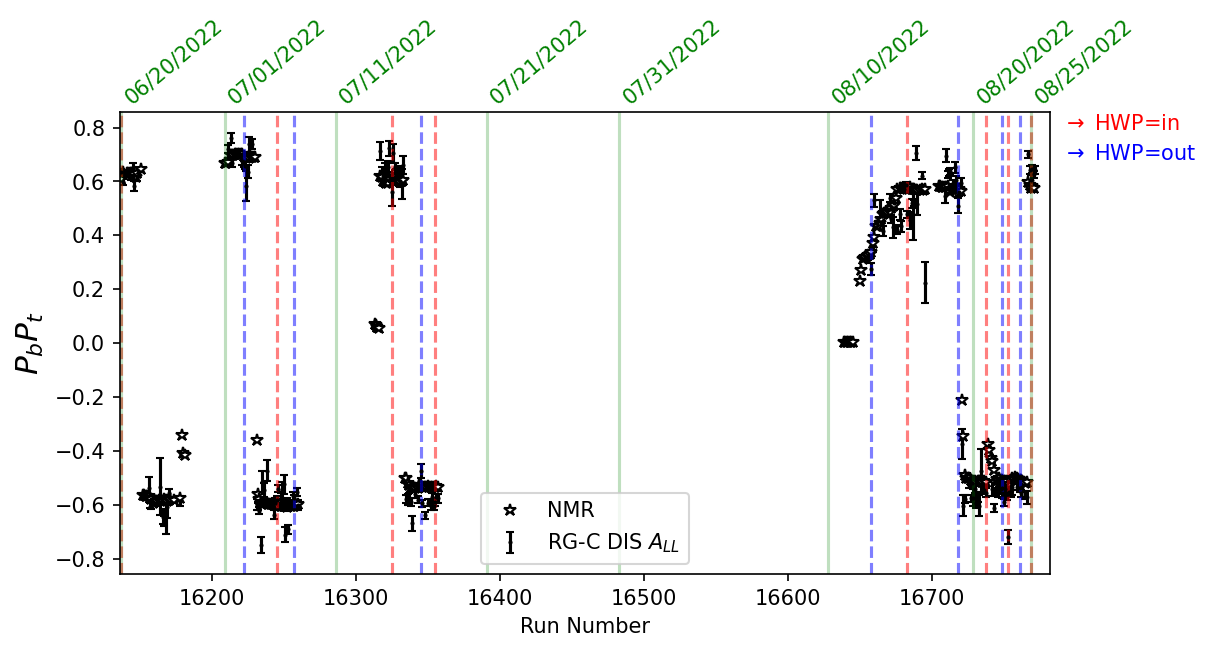

In [29]:
#df_NH3, simple_df_NH3 = process_files("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc/tpol/data/pass1/",16000,17500,"NH3")
fig4_PbPt_v2(simple_df_NH3)
#simple_df_NH3.to_csv("/work/clas12/users/gmat/RGC_5_6_2023_NH3_pol.csv")

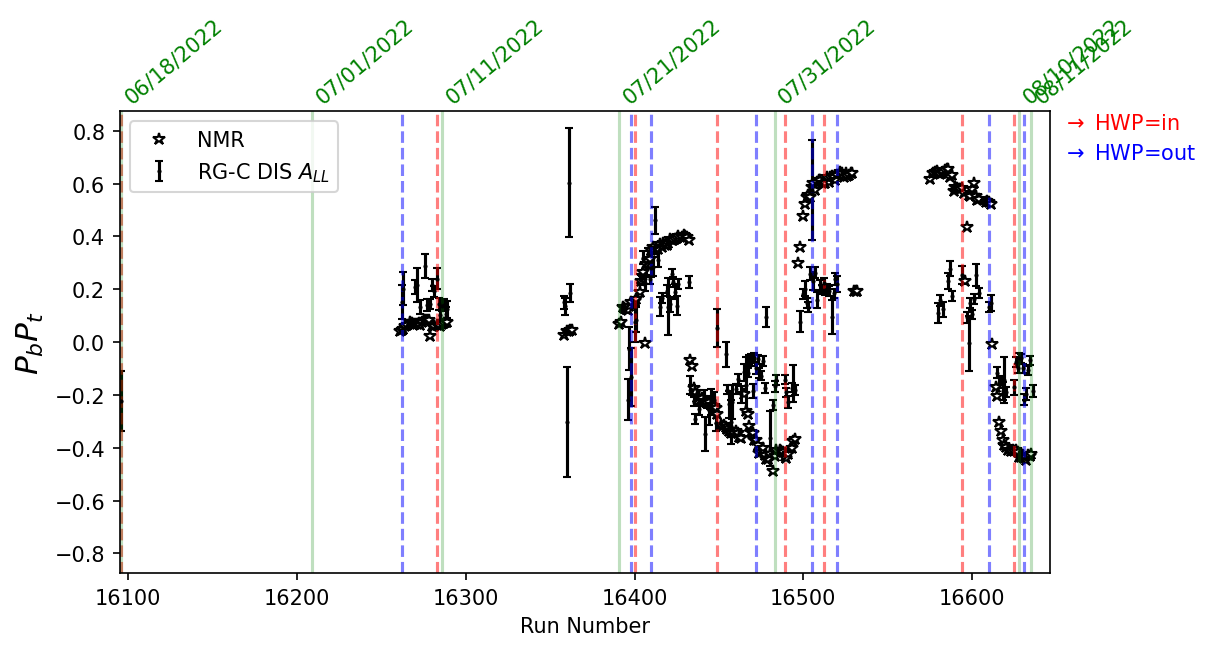

In [31]:
df_ND3, simple_df_ND3 = process_files("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc/tpol/data/pass1/",16000,17500,"ND3")
fig4_PbPt_v2(simple_df_ND3)
simple_df_ND3.to_csv("/work/clas12/users/gmat/RGC_5_6_2023_ND3_pol.csv")

In [20]:
simple_df.to_csv("/work/clas12/users/gmat/RGC_5_6_2023_NH3_pol.csv")

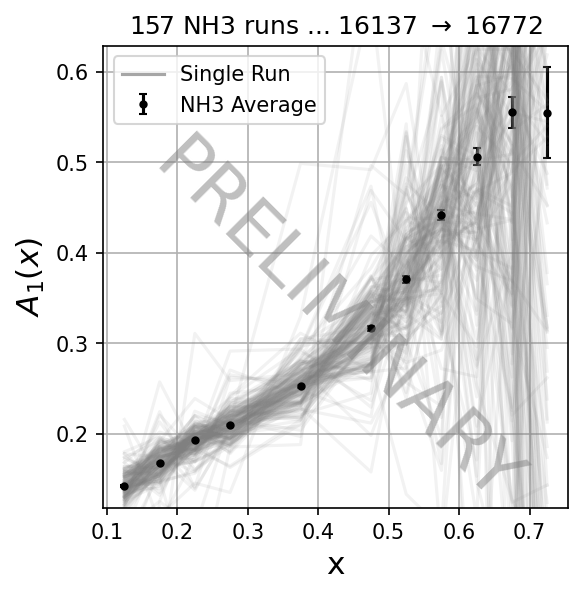

In [ ]:
fig5_A1(df,simple_df)

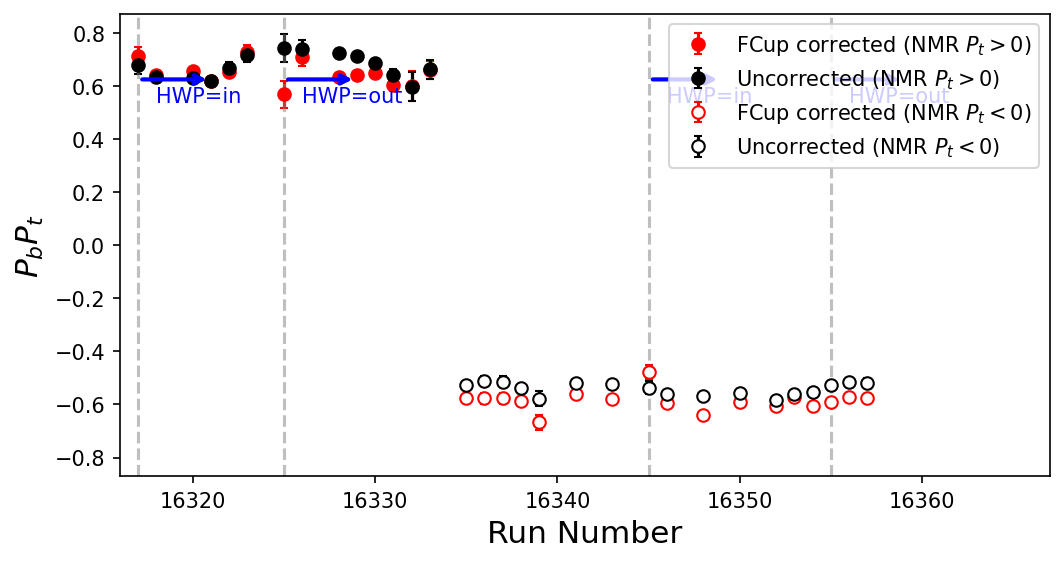

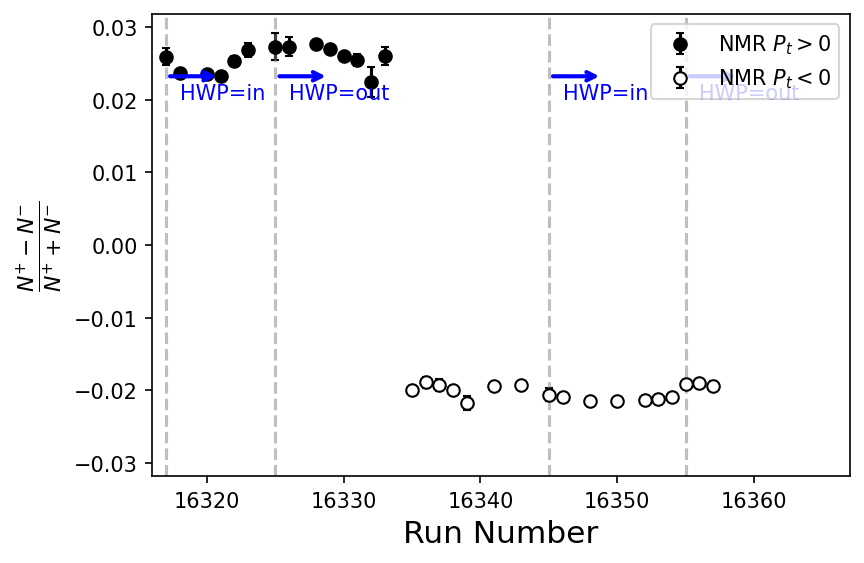

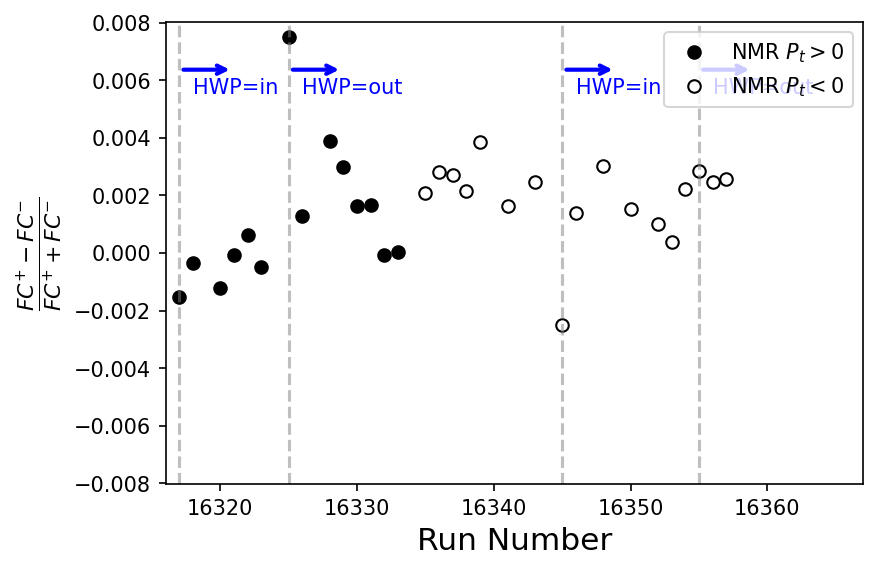

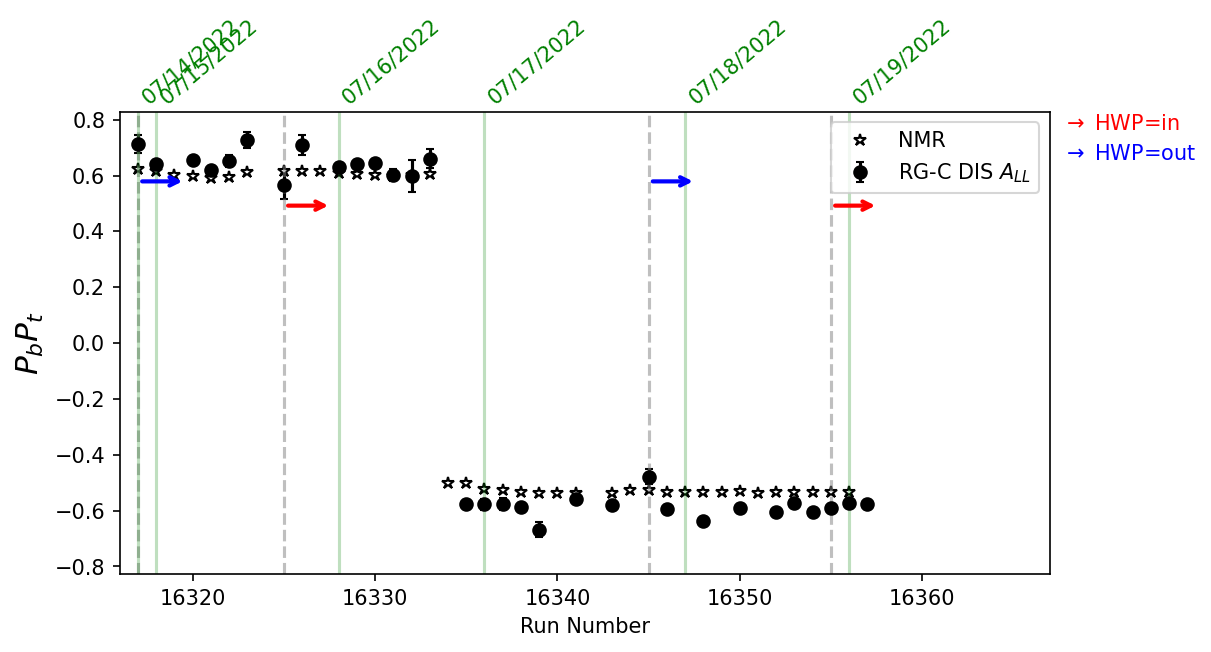

In [17]:
# NH3

file_groups = [(16317,16380), (16360,17000)]

for file_group in file_groups:
    df, simple_df = process_files("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc/tpol/data/pass1/",file_group[0],file_group[1],"NH3")
    fig1_PbPt(simple_df)
    fig2_rawAsym(simple_df)
    fig3_rawFaradayAsym(simple_df)
    fig4_PbPt_v2(simple_df)
    break

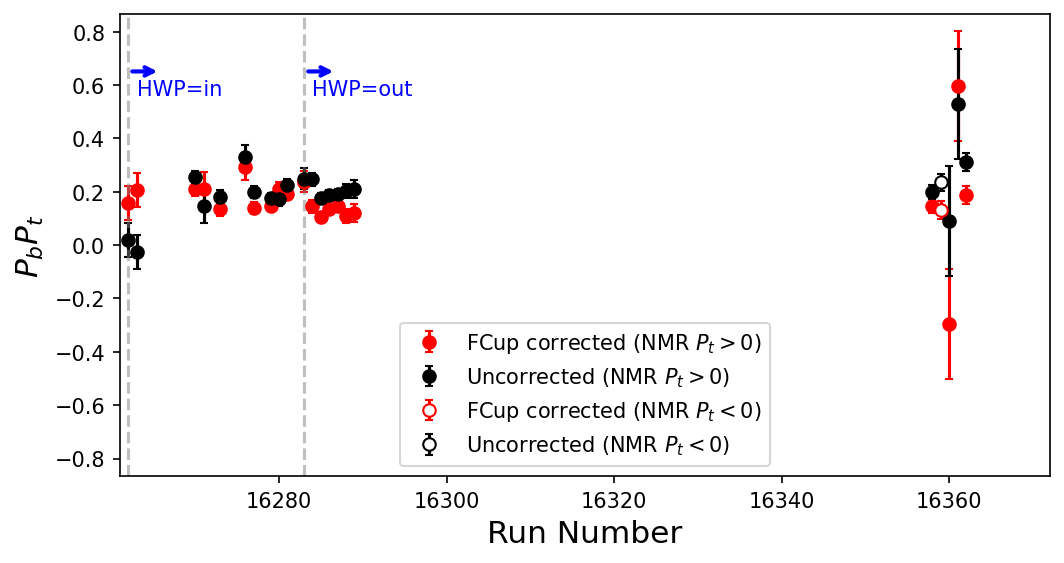

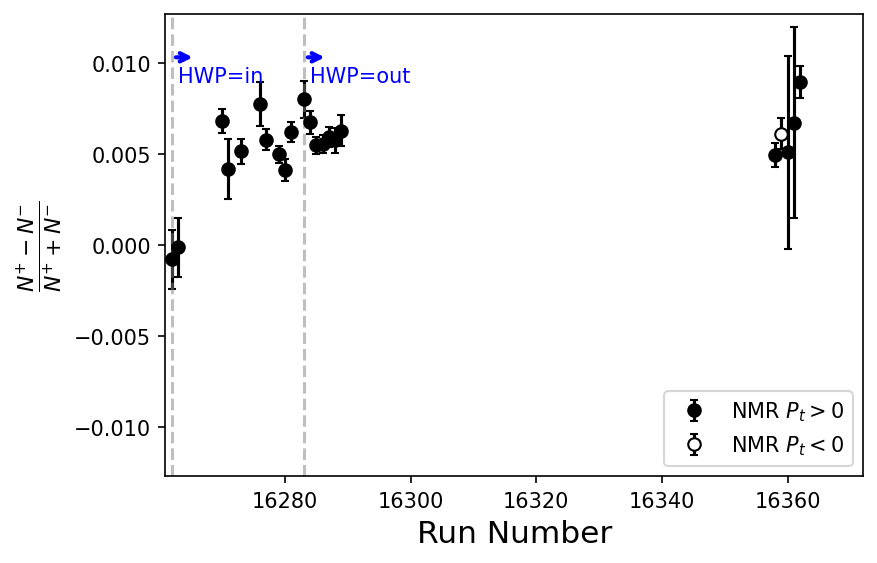

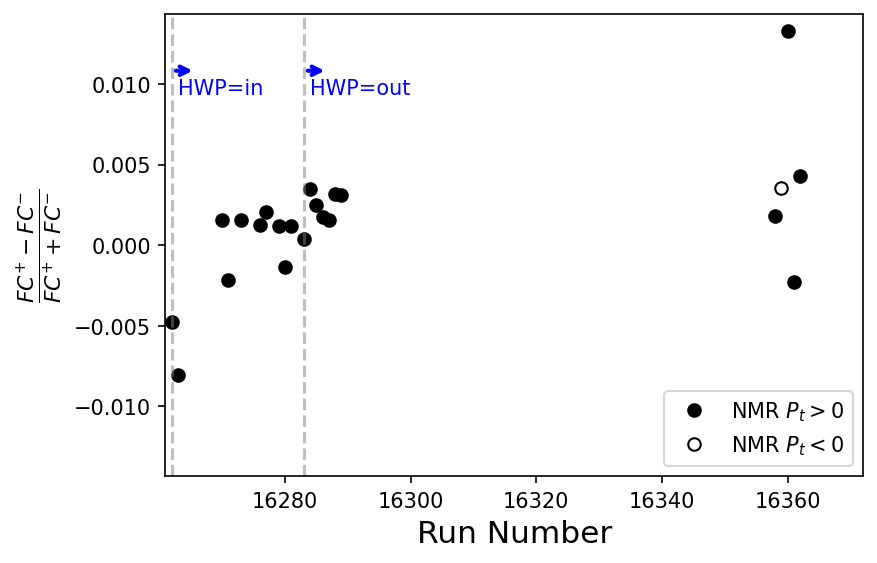

12C 
C 
C 
C 
C 
C 
C 
C 
CH2 
CH2 
CH2 
CH2 
CH2 
CH2 
Empty 
Empty 
Empty 
Empty 
Empty 
Empty 
Empty 
Empty 
Empty 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 
NH3 


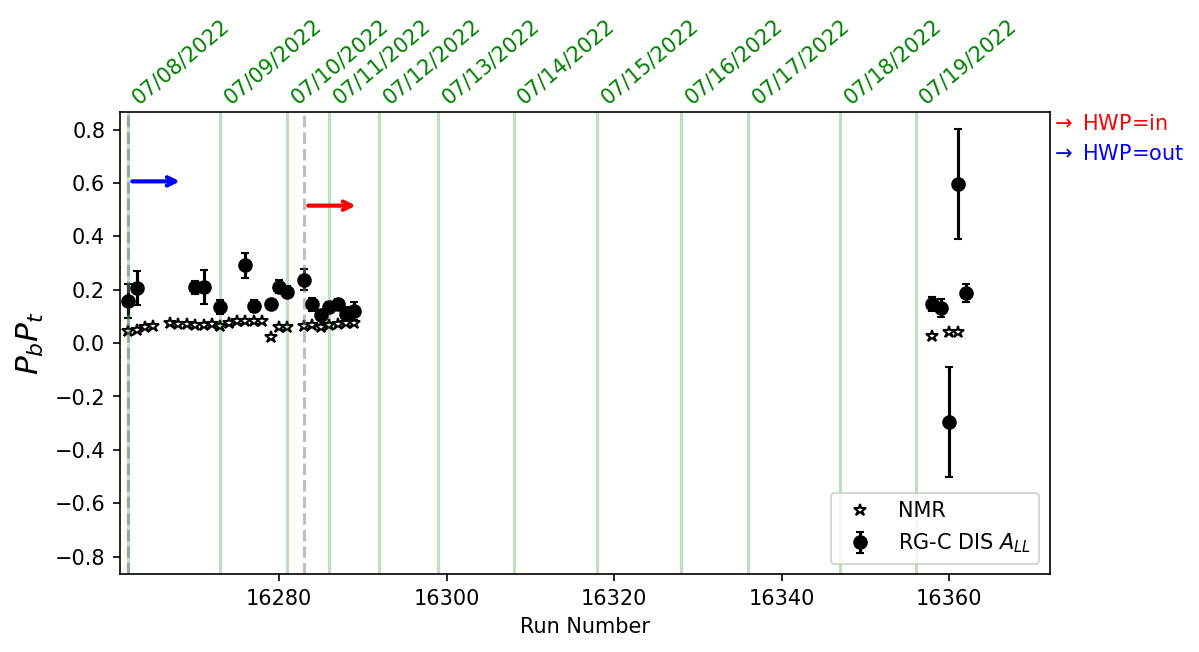

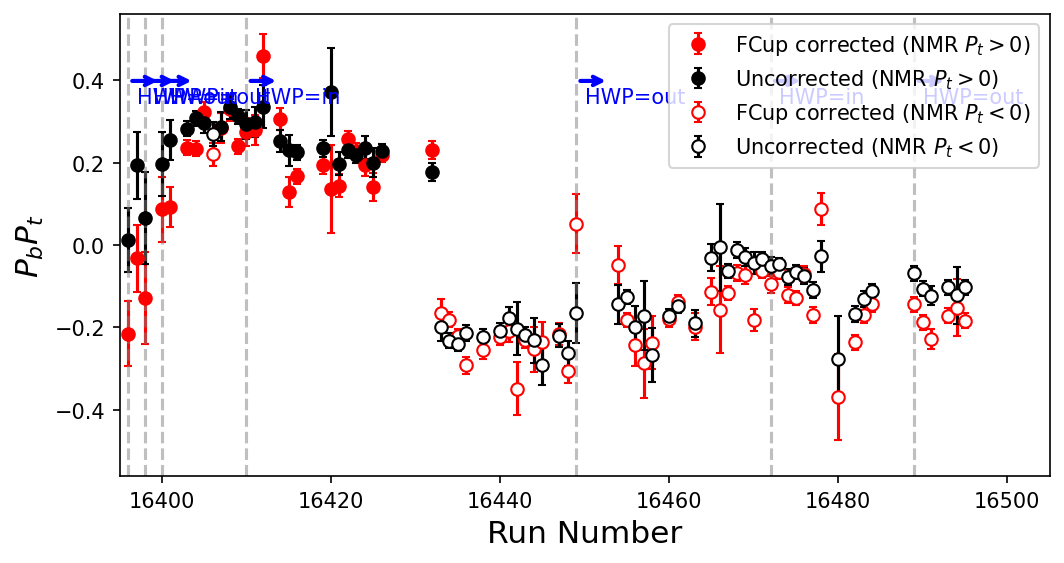

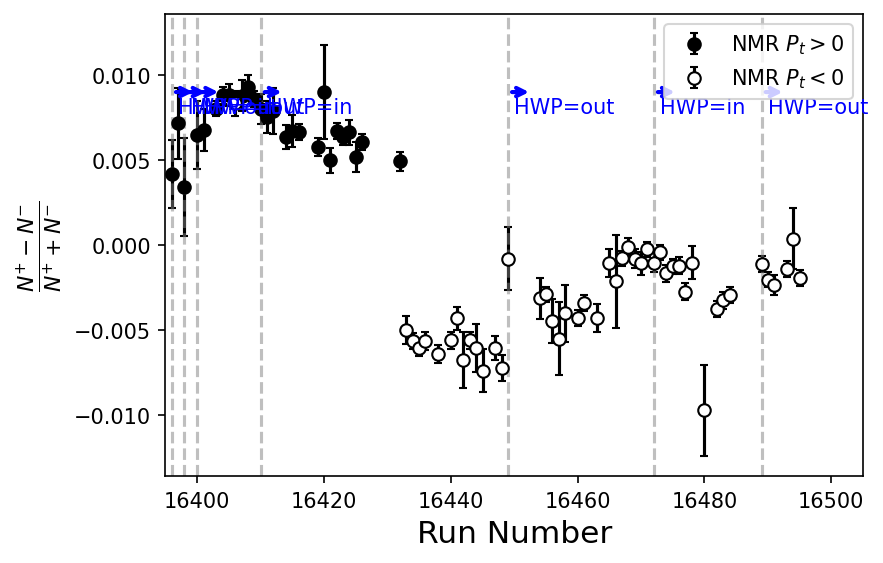

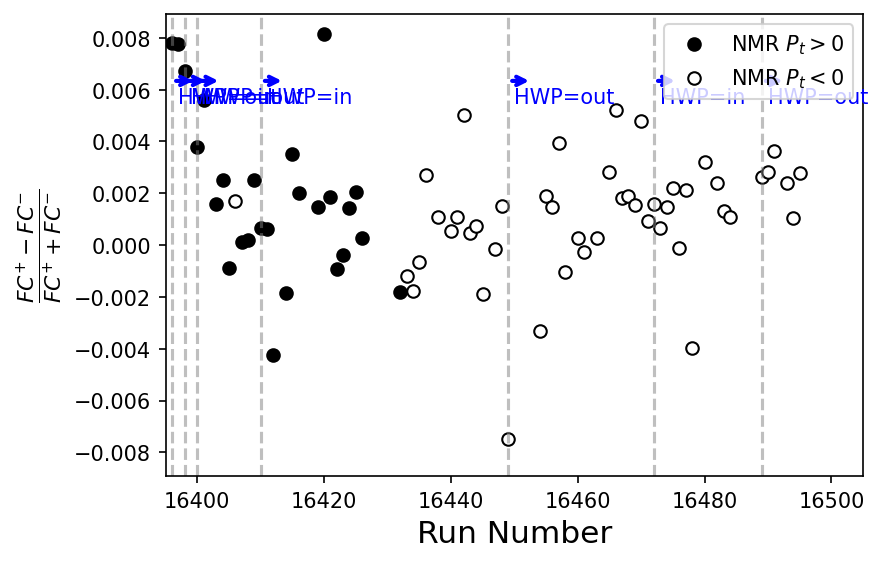

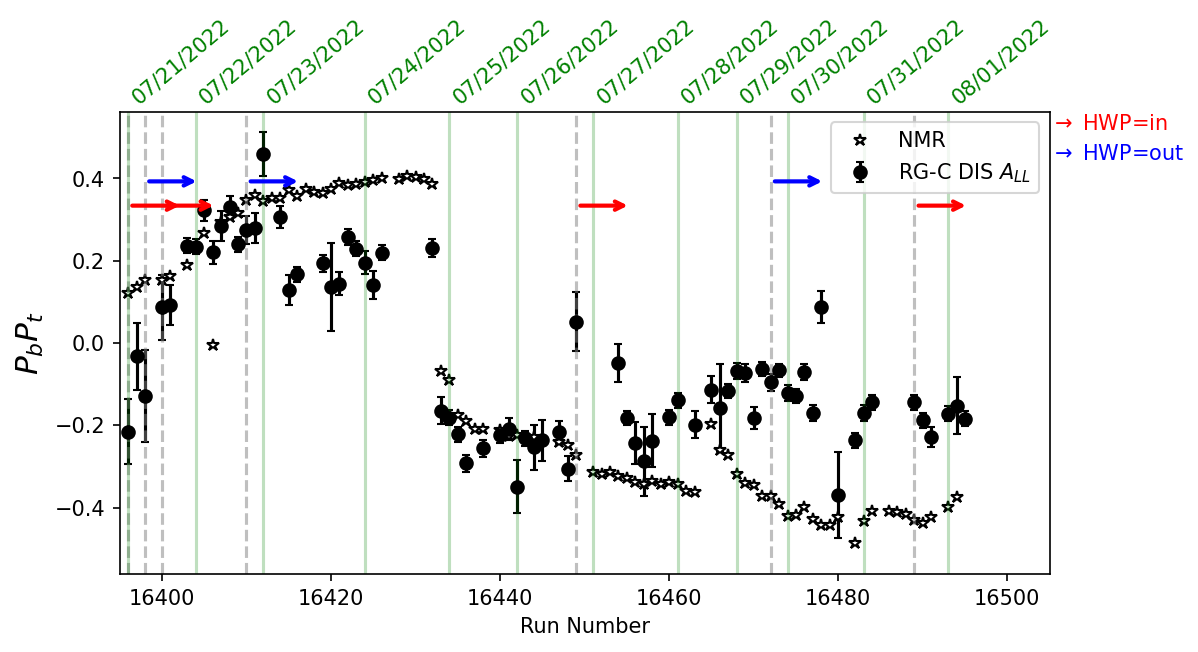

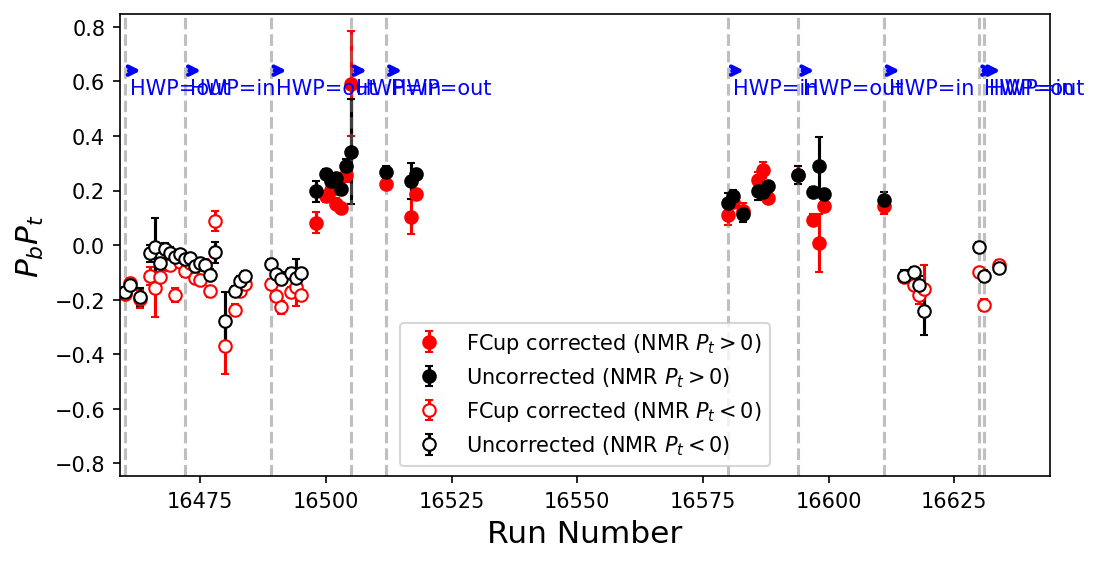

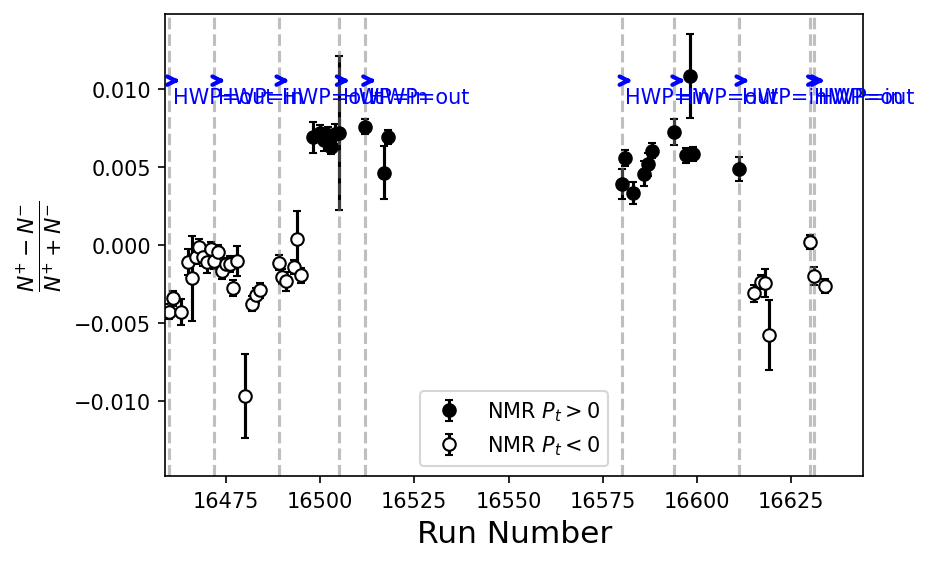

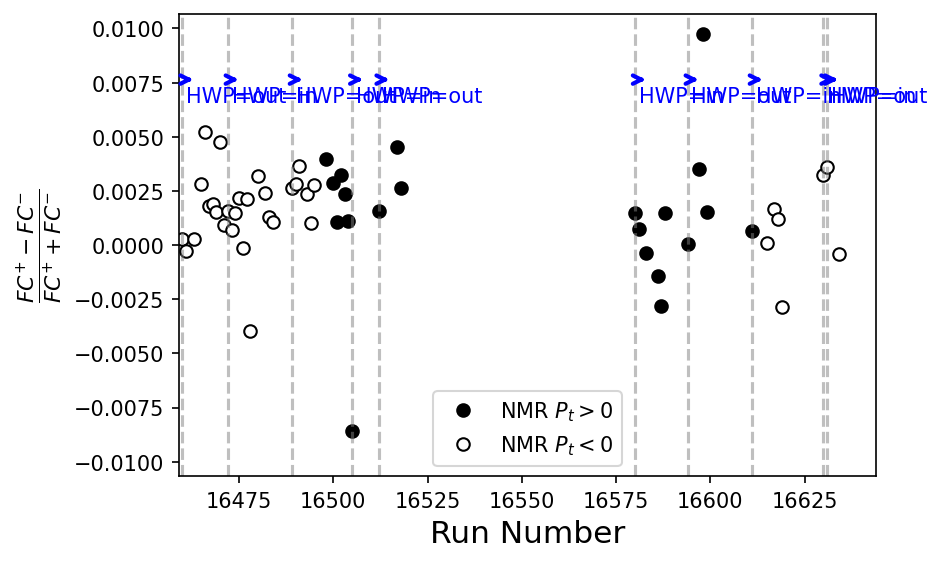

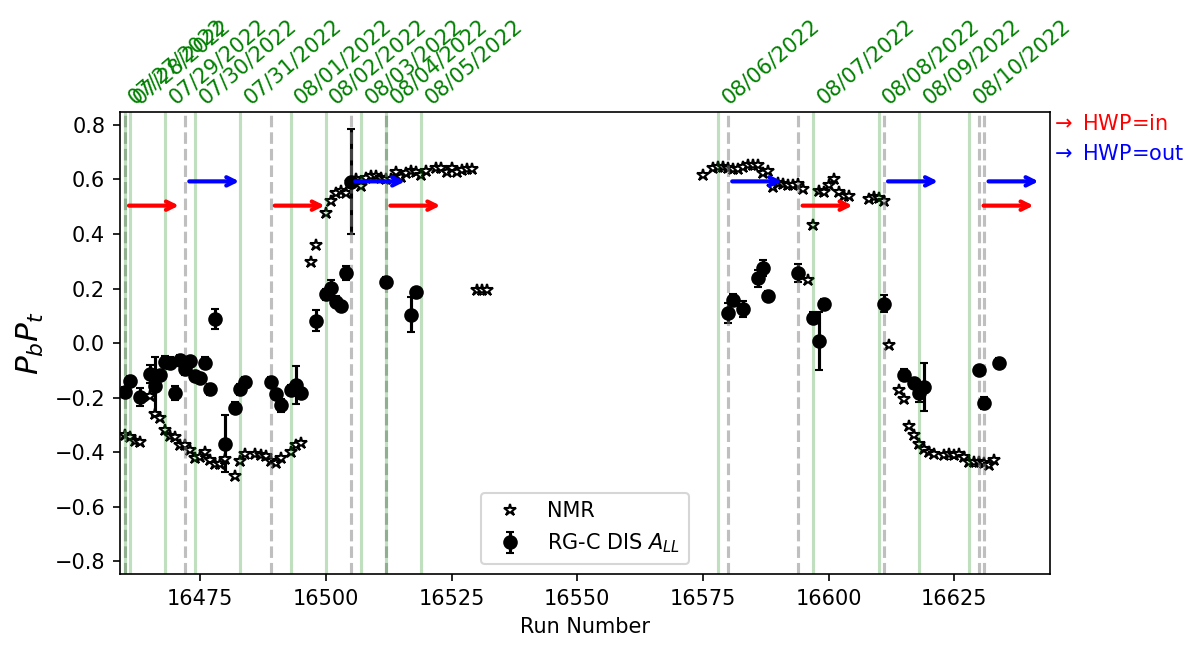

In [146]:
# ND3

file_groups = [(16000,16380), (16390,16495),(16459,17000)]

for file_group in file_groups:
    df, simple_df = process_files("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc/tpol/data/pass1/",file_group[0],file_group[1],"ND3")
    fig1_PbPt(simple_df)
    fig2_rawAsym(simple_df)
    fig3_rawFaradayAsym(simple_df)
    fig4_PbPt_v2(simple_df)

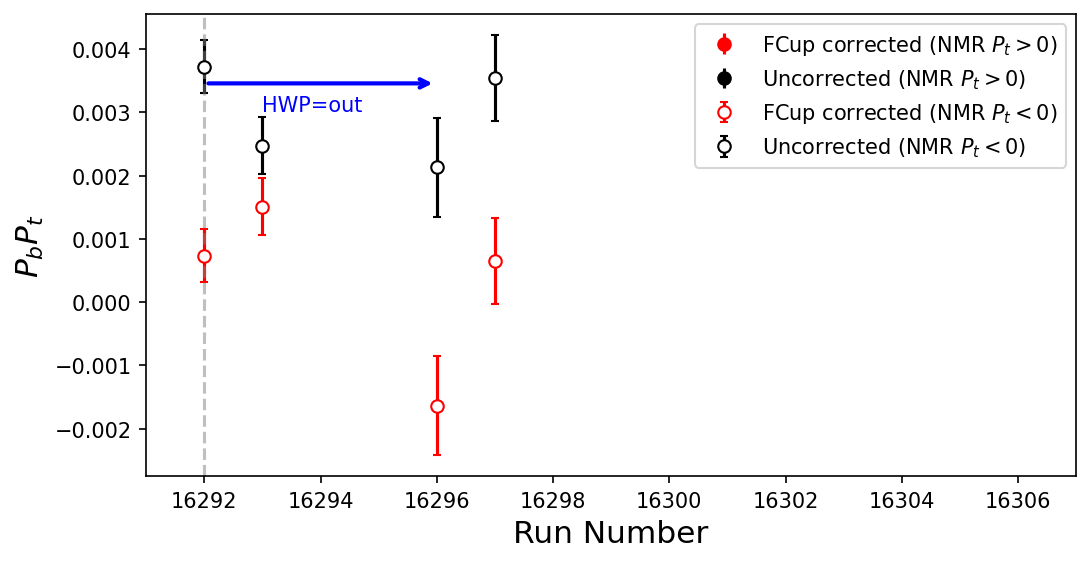

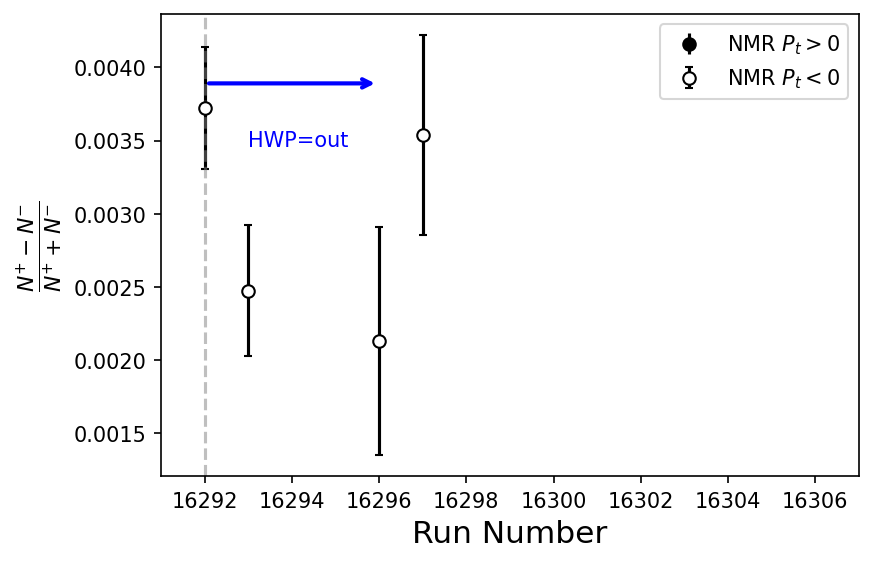

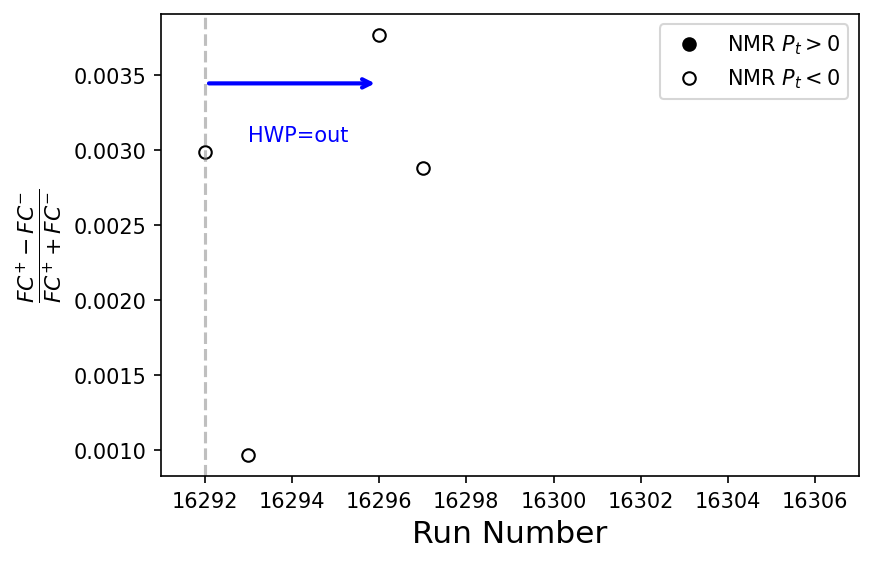

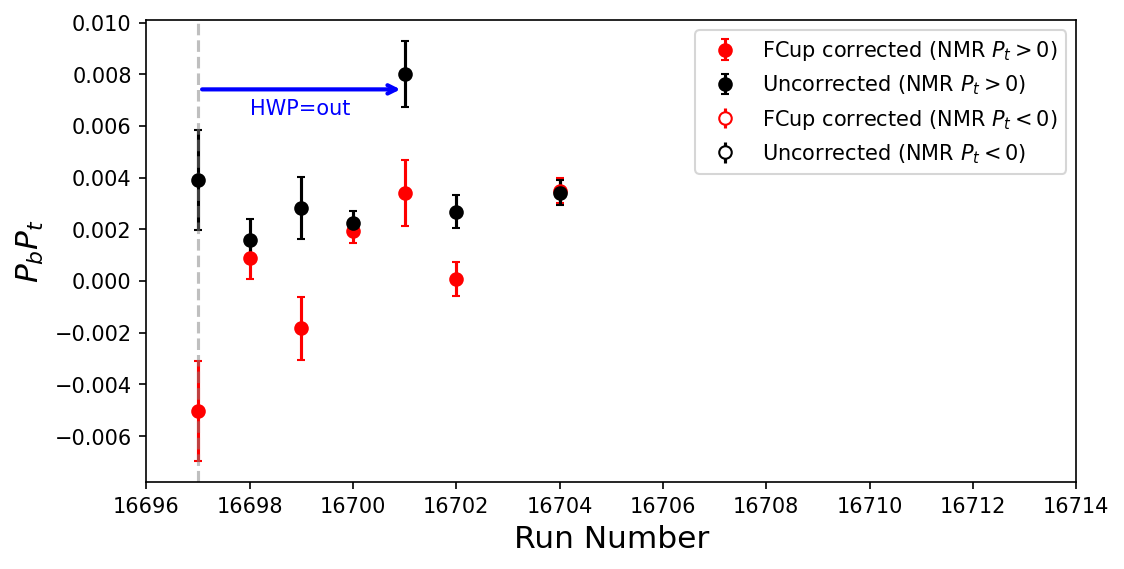

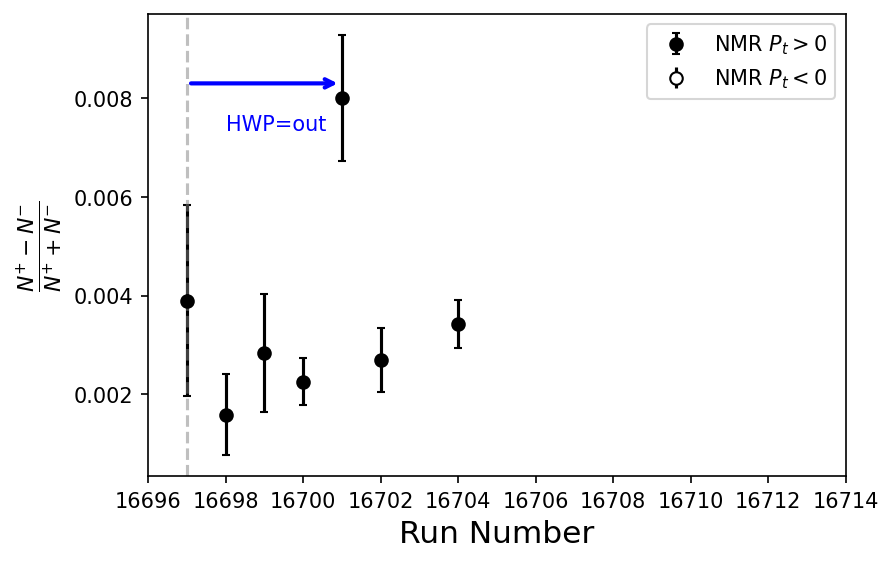

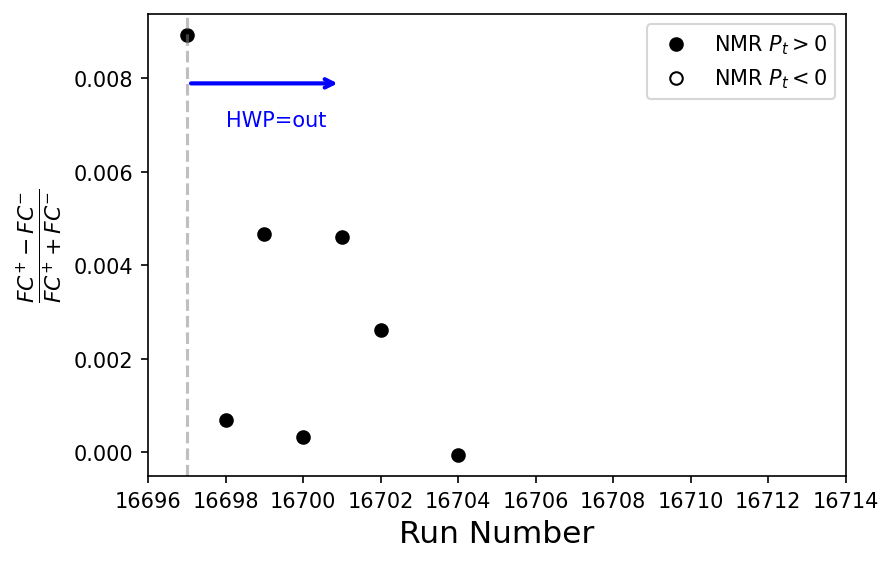

In [47]:
# CARBON

file_groups = [(16200,16400), (16695,16704)]

for file_group in file_groups:
    df, simple_df = process_files("/volatile/clas12/users/gmat/clas12analysis.sidis.data/rgc/tpol/data/pass1/",file_group[0],file_group[1],"C")
    fig1_PbPt(simple_df)
    fig2_rawAsym(simple_df)
    fig3_rawFaradayAsym(simple_df)